In [1]:
#Pacchetti per machine learning
import sys
import pandas as pd
import numpy as np
import sklearn
from sklearn import ensemble
import kmapper as km
from kmapper.plotlyviz import *
from sklearn.decomposition import PCA
import umap.umap_ as umap
import warnings
warnings.filterwarnings("ignore")

#Pacchetti per visualizzazione grafica
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

In [2]:
#Visualizzo i risultati grafici tramite una funzione-colore che associa ad ogni valore della proiezione un colore relativamente
#alla distanza dal minimo. La scala di colore utilizzata è la brewer colorscale.
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

In [5]:
#Funzione che mi permette di ottenere tutti gli oggetti grafici del complesso simpliciale da visualizzare
def visualize_scomplex(scomplex, lens2D, y, pl_brewer):
    """
    INPUT
    - scomplex: è il complesso simpliciale ottenuto dalla funzione del kmapper.mapper()
    - lens2D: è la proiezione ottenuta dalla funzione
    - y: è la classe
    - pl_brewer: è la colormap 
    """
    color_values = lens2D[:,0] - lens2D[:,0].min()
    kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                     color_values,
                                                                     color_function_name='Distance to x-min',
                                                                     colorscale=pl_brewer)

    # assign to node['custom_tooltips']  the node label (0 for without heart failure, 1 for with heart failure)
    for node in kmgraph['nodes']:
        node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

    bgcolor = 'rgba(10,10,10, 0.9)'
    y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
    plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=pl_brewer,
                                     factor_size=2.5, edge_linewidth=0.5)
    layout = plot_layout(title='Topological network representing the<br>  heart failure  dataset',
                         width=620, height=570,
                         annotation_text=get_kmgraph_meta(mapper_summary),
                         bgcolor=bgcolor)

    fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
    fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                            y_gridcolor=y_gridcolor)
    fw_summary = summary_fig(mapper_summary, height=300)
    dashboard = hovering_widgets(kmgraph,
                                 fw_graph,
                                 ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                                 bgcolor=bgcolor,
                                 y_gridcolor=y_gridcolor,
                                 member_textbox_width=600)

    #Update the fw_graph colorbar, setting its title:
    fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
    return kmgraph, fw_graph, fw_summary, fw_hist, dashboard

#Funzione che mi permette di ottenere il colore e il tooltips di ogni nodo 
def do_color_and_tooltips(kmgraph, graph, dictionar, y):
    """
    INPUT
    - kmgraph: è il grafo ottenuto dalla funzione del kmapper.get_mapper_graph()
    - graph: è l'immagine widget ottenuta dalla funzione visualize_scomplex()
    - dictionary: è il dictionary contenete le etichette dalla classificazione
    - y: è la classe
    """
    tooltips = list(graph.data[1].text) # viene effettuata questa conversione perchè fw.data[1].text è una tupla
                                       # e la trasformazione in list la rende più gestibile      

    # Esplorando ogni nodo vado a ricavare il vettore di classificazione e poi ad associare il colore in base alla 
    # classe di maggioranza di ogni nodo
    new_color = []
    for j, node in enumerate(kmgraph['nodes']):
        member_label_ids = y[scomplex['nodes'][node['name']]]
        member_labels = [heartFail_dict[id] for id in member_label_ids]
        label_type, label_counts = np.unique(member_labels, return_counts=True)

        n_members = label_counts.sum()
        if label_type.shape[0] == 1:
            if label_type[0] == 'without heart failure':
                new_color.append(0)
            else:
                new_color.append(1)
        else:
            new_color.append(1.0*label_counts[1]/n_members)

        for m in range(len(label_counts)):
            tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) # riporto anche il numero dei pazienti
                                                                                    # che compongono ogni classe in ogni nodo
    return new_color, tooltips 

#Funzione che permette di creare un elemento con due grafici arricchiti di informazioni aggiuntive in termini di colore 
def do_enrichmentGraph(graph, tooltips, new_color, title):
    """
    INPUT
    - graph: è l'immagine widget ottenuta dalla funzione visualize_scomplex()
    - tooltips: è il label contenete la classificazione di ogni nodo
    - new_color: è il colore di ogni nodo dovuto alla classe di maggioranza 
    - title: è il titolo del grafo
    """
    fwn_graph = go.FigureWidget(graph) # ricopio la FigureWidget iniziale
    with fwn_graph.batch_update(): # aggiorno la nuova figure
        fwn_graph.data[1].text = tooltips # aggiungo i nuovo tooltips
        fwn_graph.data[1].marker.colorbar.x = -0.14 # posiziono la toolbar a sinistra della figura
        fwn_graph.layout.width = 550 # cambio la dimensioni della figure per poter eseguire due plot "paralleli" 
        fwn_graph.layout.height = 550
        fwn_graph.layout.margin.r = 45 # diminuisco il margine destro da 60px (default val) a 45 pixels

    fw1 = go.FigureWidget(fwn_graph) # definisco una nuova figura da fwn_graph che sarà colorata tramite la funzione
    with fw1.batch_update():
        fw1.data[1].marker.color = new_color # aggiorno il colore dei nodi
        fw1.data[0].line.color = 'rgb(125,125,125)' # aggiorno il colore degli edge
        fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
        fw1.layout.annotations = None # rimuovo il mapper_summary dal secondo plot
        fw1.data[1].marker.showscale = False # rimuovo la colorbar
        fw1.layout.title = title
    return fwn_graph, fw1

#Funzione che permette di confrontare la capacità delle lenti di dividere le classi
def do_lensPlot(lens1, name1, lens2, name2):
    """
    INPUT
    - lens1: è la proiezione ottenuta dalla funzione X
    - name1: è il nome della funzione utilizzata
    - lens2: è la proiezione ottenuta dalla funzione Y
    - name2: è il nome della funzione utilizzata
    """
    fig, axs = plt.subplots(1, 1, figsize=(5,4))
    axs.scatter(lens1,lens2,c=y.reshape(-1,1),alpha=0.3)
    axs.set_xlabel(name1)
    axs.set_ylabel(name2)
    return fig, axs
    

In [6]:
#Lettura del dataset
#In questo modo il dataSet avrà gli ID_PZ come chiavi (indici) rendendo più semplice l'accesso 
df = pd.read_csv("C:/Users/Antonio Montanaro/Desktop/Tesi Magistrale/File Memory/DatiTesi.csv", index_col = 1)

#Rimuovo la colonna 'Unamed'
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

#Dato che un paziente ha un BMI oltre il limite massimo, verrà eliminato
i = df[((df['bmi'] == df['bmi'].max()))].index
df = df.drop(i)

#Rimuovo le colonne superflue per il tipo di analisi
df.drop(df.columns[df.columns.str.contains('statine',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('altri_farmaci',case = False)],axis = 1, inplace = True)

#Estraggo il nome delle variabili (continue/categoriche)
feature_names = [c for c in df.columns if c not in ["id_pz", "classe_canadian_society", "classe_nyha"]]
df["classe_nyha"] = df["classe_nyha"].apply(lambda x: 0 if x == 0 else 1) 
df["classe_canadian_society"] = df["classe_canadian_society"].apply(lambda x: 0 if x == 0 else 1) 

#Creo una copia del dataset senza modificarlo (potrebbe ritornare utile)
dataSet = df;

#Trasformo il dataset "df" in un formato matrice numpy
X = np.array(df[feature_names].fillna(0))

#Divido il dataSetFeatures in una parte che contiene sono le features continue e in un altra con le categoriche
XcontFeatures = df.loc[:, ~df.columns.isin(['sesso','fumo','ipertensione','ipercolesterol','arteriopatia','anemia','irc','sindr_trombofilica'])]
XcatFeatures =  df.loc[:, df.columns.isin(['sesso','fumo','ipertensione','ipercolesterol','arteriopatia','anemia','irc','sindr_trombofilica'])]
XcatFeaturesND = XcatFeatures

#Opzione che mi permette di stampare e quindi visualizzare l'interno dataset 
pd.set_option("display.max_rows", None, "display.max_columns", None) #To view entire dataframe

#Trasformo le categoriche in dummy: le colonne categoriche sono: Sesso [1 = M e 2 = F] Fumo [1 = Mai 2 = Si e 3 =ex] 
#e Ipertensione, Ipercolesterolemia, Arteriopatia Periferica, Anemia, IRC, Sindrome Trombofilica, Statine, 
#Altri Farmaci [-1 = non noto, 0 = no e 1 = si]
XcatFeatures = pd.get_dummies(XcatFeatures, columns=['sesso','fumo','ipertensione','ipercolesterol','arteriopatia','anemia','irc','sindr_trombofilica',], drop_first=True)

#Normalizzo il dataSet continuo
#La normalizzazione dei dati deve essere fatta solo per le variabili continue
XcontFeatures -= XcontFeatures.min() 
XcontFeatures /= XcontFeatures.max() 

#Ricostruisco il dataset X completo per poter implementare l'algortimo TDA
X = pd.merge(left=XcontFeatures, right=XcatFeatures, how='outer', on='id_pz')
# Poichè il dataSet X è eterogeneo affinchè il TDA funzioni in modo adeguato è necessario che X venga reso omogeneo 
# attraverso una misura di similarità, in questo caso similarità coseno
from sklearn.metrics.pairwise import cosine_similarity
X = cosine_similarity(X)

#Estraggo il vettore contenente la classificazione degli esempi
y = np.array(df["classe_nyha"])

#Creo tutte le varie proeizione tramite le diverse funzioni
#Creo una proiezione tramite funzione Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

#Creo una proiezione tramite funzione L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

#Combino le lenti in modo da ottenere un vettore bi-dimensionale [Isolation Forest, L^2-Norm]
lens = np.c_[lens1, lens2]

# Creare una lente 1-D con First Principal Component 
lens3 = mapper.fit_transform(X, projection=PCA(n_components=1))

# Combino le lenti per avere una proiezione 2-D i.e. [Isolation Forest,PCA]
isoForest_pca = np.c_[lens1, lens3]

# Creo una proiezione 1-D con i valori della variabile texture_mean del dataset
lens4 = mapper.fit_transform(X, projection=[1])

# Combino le lenti per ottenere una proiezione 2-D i.e. [Texture_mean, L2 Norm]
texture_l2norm = np.c_[lens4, lens2]

# Creo una proiezione 1-D con i valori della prima componente Umap
lens5 = mapper.project(X, projection=umap.UMAP(n_components=1))

#Combino le lenti per ottenere una proiezione 2-D i.e. [Lens_X, Umap]
isoforest_umap = np.c_[lens1, lens5]
l2Norm_umap = np.c_[lens2, lens5]
pca_umap = np.c_[lens3, lens5]

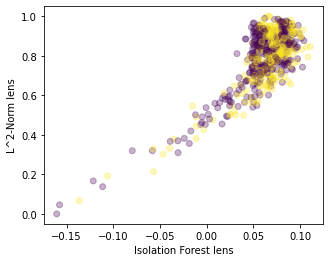

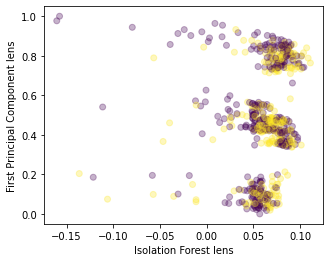

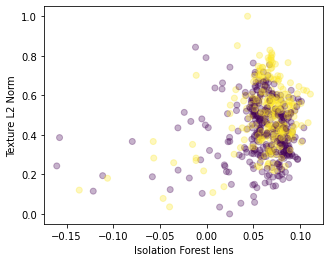

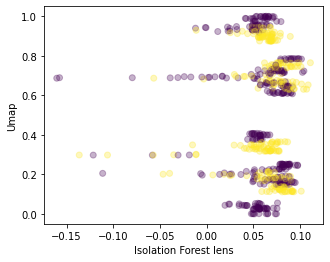

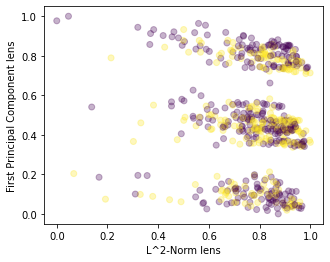

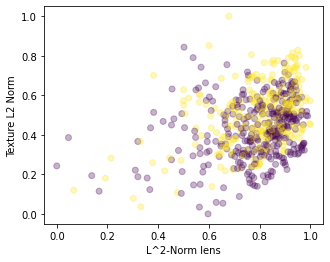

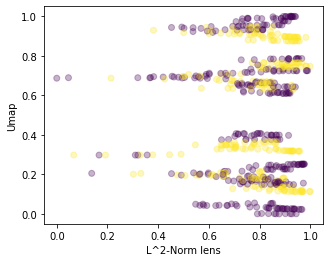

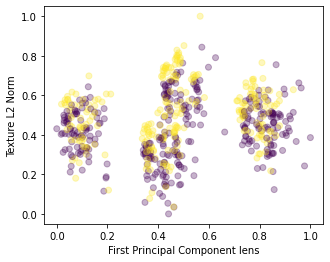

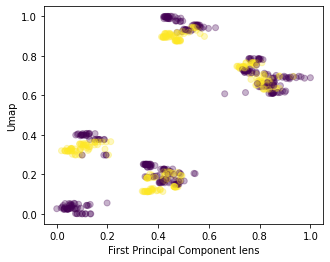

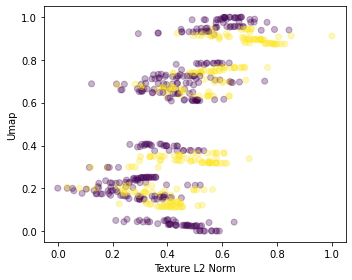

In [7]:
# Prima di costruire i complessi simpliciali con queste lenti, esamino le capacità delle proiezioni di separare i dati 
# dal punto di vista della classe:
do_lensPlot(lens1, 'Isolation Forest lens', lens2, 'L^2-Norm lens')
do_lensPlot(lens1, 'Isolation Forest lens', lens3, 'First Principal Component lens') 
do_lensPlot(lens1, 'Isolation Forest lens', lens4, 'Texture L2 Norm')
do_lensPlot(lens1, 'Isolation Forest lens', lens5, 'Umap')

do_lensPlot(lens2, 'L^2-Norm lens', lens3, 'First Principal Component lens') 
do_lensPlot(lens2, 'L^2-Norm lens', lens4, 'Texture L2 Norm')
do_lensPlot(lens2, 'L^2-Norm lens', lens5, 'Umap')

do_lensPlot(lens3, 'First Principal Component lens', lens4, 'Texture L2 Norm')
do_lensPlot(lens3, 'First Principal Component lens', lens5, 'Umap') 

do_lensPlot(lens4, 'Texture L2 Norm', lens5, 'Umap')

plt.tight_layout()
plt.show()

In [8]:
#Costruisco i vari complessi simpliciali con le diverse lenti tramite una funzione TDAMapper
scomplex = mapper.map(lens,
                      X,
                      cover=km.Cover(n_cubes=15, perc_overlap=0.7),  #Modifica rispetto al github causa versione del mapper
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex, lens, y, pl_brewer)
VBox([graph, HBox([summary, hist])])
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

Successivamente mostro come è possibile andare a duplicare una FigureWidget(s) e modifarne alcuni attributi
In questo modo sarà possibile mostrare come si può manipolare l'output del kmapper.map(...) e visualizzarlo

Viene duplicato la FigureWidget iniziale: fw_graph e ricolorati i nodi in accordo alla proporzione della classe di maggioranza dei pazienti interni ad ogni nodo. Le due FigureWidgets saranno graficate in parallelo per facilitarne il confronto

In [9]:
#Definisco un dictionary contente il label della classificazione
heartFail_dict = {0: 'with CAD Class 0', 1: 'with CAD Class 1'}                                                                       
new_color, tooltips = do_color_and_tooltips(kmgraph, graph, heartFail_dict, y)
fwn_graph, fw1 = do_enrichmentGraph(graph, tooltips, new_color, "Nodes are colored according to the proportion<br> of CAD class's members")
        
# Grafico i risultati in due figure:
HBox([fwn_graph, fw1])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

Note sulla scelta della lente
La ragione sottostante la scelta della lente è:

Per lens1: funzioni filtro che hanno un senso biologico; in altre parole, funzione che sottolineano speciali caratterisiche nei dati. In questo particolare caso, in cui si ha a che fare con questi dati, usare uno score di detezione di anomalia (in questo caso calcolato tramite IsolationForest di sklearn) ha un senso biologico poichè le malattia cardiovascolari sono anomali.

Per lens2: funzione che disperdono i dati, in contrasto al clustering che unisce punti insieme. 


In [10]:
# Definisco i complessi simpliciali
scomplex_isoForest = mapper.map(lens1,
                      X,
                      cover= km.Cover(n_cubes=15, perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_isoForest
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_isoForest, lens1, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [11]:
# Definisco i complessi simpliciali
scomplex_isoForest_pca = mapper.map(isoForest_pca,
                      X,
                      cover= km.Cover(n_cubes=15, perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_isoForest_pca
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_isoForest_pca, isoForest_pca, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [12]:
# Definisco il complesso simpliciale
scomplex_texture = mapper.map(lens4,
                      X,
                      cover = km.Cover(n_cubes=15,perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_texture
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_texture, lens4, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [13]:
# Definisco il complesso simpliciale
scomplex_texture_l2norm = mapper.map(texture_l2norm,
                      X,
                      cover = km.Cover(n_cubes=15, perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_texture_l2norm
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_texture_l2norm, texture_l2norm, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [14]:
# Definisco il complesso simpliciale
scomplex_isoforest_umap = mapper.map(isoforest_umap,
                      X,
                      cover = km.Cover(n_cubes=15,perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_isoforest_umap
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_isoforest_umap, isoforest_umap, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [15]:
# Definisco il complesso simpliciale
scomplex_l2Norm_umap = mapper.map(l2Norm_umap,
                      X,
                      cover = km.Cover(n_cubes=15, perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))

# Visualizzo i complessi simpliciali: scomplex_l2Norm_umap
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_l2Norm_umap, l2Norm_umap, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [16]:
# Definisco il complesso simpliciale
scomplex_pca_umap = mapper.map(pca_umap,
                      X,
                      cover = km.Cover(n_cubes=15, perc_overlap=0.7),
                      clusterer=sklearn.cluster.KMeans(n_clusters=2,
                                                       random_state=3471))
# Visualizzo i complessi simpliciali: scomplex_pca_umap
kmgraph, graph, summary, hist, dashboard = visualize_scomplex(scomplex_pca_umap, pca_umap, y, pl_brewer)
VBox([graph, HBox([summary, hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

Lens legend
- Lens1 : Isolation Forest
- Lens2 : L2 Norm
- Lens3 : PCA (1 component)
- Lens4 : Texture_l2norm
- Lens5 : Umap